# Summary:
This project will be used to try to find the model that can more accurately predict what customers are going to 
leave the company by trying to target the EndDate column with a desired result of No in order to make the prediction. 
By finding what customers are most likely to leave we can identify what makes customers stay and implement strategies in order to 
increase customer retention.

In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.utils import resample
from scipy.stats import uniform, randint
import numpy as np

In [2]:
contract_data = pd.read_csv('/datasets/final_provider/contract.csv')
personal_data = pd.read_csv('/datasets/final_provider/personal.csv')
internet_data = pd.read_csv('/datasets/final_provider/internet.csv')
phone_data = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
display(contract_data.head())
display(personal_data.head())
display(internet_data.head())
display(phone_data.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [4]:
display(contract_data.info())
display(personal_data.info())
display(internet_data.info())
display(phone_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

## Combined all sets of data into one set by merging them.

In [5]:
merged_df = pd.merge(contract_data, personal_data, on='customerID', how='inner')
merged_df_2 = pd.merge(internet_data, merged_df, on='customerID', how='inner')
final_df = pd.merge(phone_data, merged_df_2, on='customerID', how='inner')

In [6]:
display(final_df.head())

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
0,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No
1,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No
2,9237-HQITU,No,Fiber optic,No,No,No,No,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No
3,9305-CDSKC,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No
4,1452-KIOVK,Yes,Fiber optic,No,Yes,No,No,Yes,No,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes


## Changed data types and verified that there were no missing values.

In [7]:
final_df['BeginDate'] = pd.to_datetime(final_df['BeginDate'])

In [8]:
numeric_col = pd.to_numeric(final_df['TotalCharges'], errors='coerce')

non_numeric_values = final_df['TotalCharges'][numeric_col.isna()]

In [9]:
final_df['TotalCharges'] = pd.to_numeric(final_df['TotalCharges'].str.strip(), errors='coerce')

In [10]:
final_df[final_df['TotalCharges'].isnull()]

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
663,5709-LVOEQ,No,DSL,Yes,Yes,Yes,No,Yes,Yes,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes
4573,4075-WKNIU,Yes,DSL,No,Yes,Yes,Yes,Yes,No,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes
4630,2775-SEFEE,Yes,DSL,Yes,Yes,No,Yes,No,No,2020-02-01,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,Male,0,No,Yes


In [11]:
final_df['TotalCharges'] = final_df['TotalCharges'].fillna(0)

In [12]:
final_df.isnull().sum()

customerID          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
dtype: int64

In [13]:
final_df = final_df.drop('customerID', axis=1)

## Here we are looking at unique values to see which are binary.
For non-binary values we need to decide whether they need to be encoded or not. 

In [14]:
final_df.nunique()

MultipleLines          2
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1278
TotalCharges        4628
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
dtype: int64

In [15]:
final_df.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,4835.000000,4835.000000,4835.000000
mean,81.755171,2900.669876,0.203930
std,18.303085,2415.896065,0.402959
min,42.900000,0.000000,0.000000
25%,69.775000,658.725000,0.000000
50%,82.500000,2347.900000,0.000000
75%,95.700000,4870.275000,0.000000
max,118.750000,8684.800000,1.000000


## Boxplot showed that the data for TotalCharges was positively skewed. 

<AxesSubplot:>

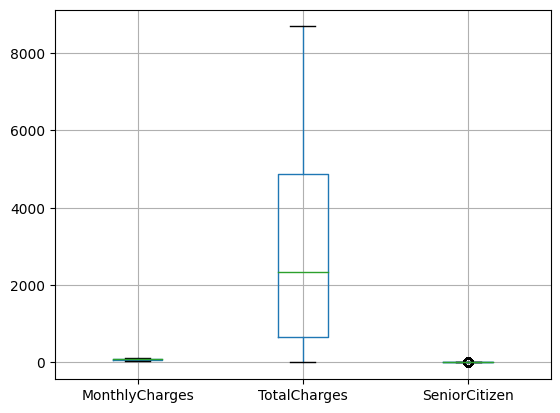

In [16]:
final_df.boxplot()

In [17]:
final_df['EndDate'].value_counts()

No                     3249
2019-11-01 00:00:00     414
2019-10-01 00:00:00     401
2019-12-01 00:00:00     392
2020-01-01 00:00:00     379
Name: EndDate, dtype: int64

## Transformed all values other than No into Yes so that we could have a binary target.

In [18]:
value_to_keep = 'No'
new_value = 'Yes'
final_df.loc[final_df['EndDate'] != value_to_keep,'EndDate'] = new_value

In [19]:
final_df['EndDate'].value_counts()
final_df['EndDate'] = final_df['EndDate'].astype('category').cat.set_categories(['Yes', 'No'])

## Encoded features to change them from object to Int types.

In [20]:
categorical_features = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
        'gender', 'SeniorCitizen', 'Partner', 'Dependents']

In [21]:
df_encoded = pd.get_dummies(final_df, columns=categorical_features, drop_first=True, dtype=int)

## Created a new feature in order to calculate customer tenure and dropped BeginDate since it was the wrong data type.

In [22]:
ref_date = pd.to_datetime('2020-02-01')
difference = ref_date - df_encoded['BeginDate']

In [23]:
active_years = difference.dt.days / 365
active_years = active_years.round()
active_months = active_years * 12

In [24]:
df_encoded['active_months'] = active_months.astype(int)

In [25]:
df_encoded.describe()

,MonthlyCharges,TotalCharges,MultipleLines_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,...,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,active_months
count,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,...,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,81.755171,2900.669876,0.543744,0.640331,0.359049,0.443020,0.437849,0.362978,0.500931,0.503413,...,0.185315,0.690383,0.214478,0.417166,0.147260,0.501551,0.203930,0.486660,0.260807,34.143537
std,18.303085,2415.896065,0.498134,0.479953,0.479771,0.496794,0.496174,0.480908,0.500051,0.500040,...,0.388593,0.462384,0.410502,0.493142,0.354401,0.500049,0.402959,0.499874,0.439120,24.943562
min,42.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,69.775000,658.725000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,82.500000,2347.900000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,36.000000
75%,95.700000,4870.275000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,60.000000
max,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,72.000000


## Chose the best columns and dropped all others then split the data.

In [26]:
cols_to_drop = ['BeginDate', 'MultipleLines_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
                'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'SeniorCitizen_1']

df_encoded = df_encoded.drop(columns=cols_to_drop).drop_duplicates()

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df_encoded.drop('EndDate_No', axis=1), 
    df_encoded['EndDate_No'], 
    test_size=0.3,  
    random_state=42,  
    stratify=df_encoded['EndDate_No'] 
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  
    random_state=42,
    stratify=y_temp 
)

In [28]:
X_train = X_train.copy()
X_test = X_test.copy() 
X_val = X_val.copy()

## Transformed the data on TotalCharges in order to reduce positive skew then upsampled data to fix imbalance of classes.

In [29]:
X_train.loc[:, 'TotalCharges'] = np.log1p(X_train['TotalCharges'])
X_test.loc[:, 'TotalCharges'] = np.log1p(X_test['TotalCharges'])
X_val.loc[:, 'TotalCharges'] = np.log1p(X_val['TotalCharges'])

In [30]:
majority_class = X_train[y_train == 1]
minority_class = X_train[y_train == 0]

minority_upsampled = resample(minority_class,
                               replace=True,   
                               n_samples=len(majority_class),   
                               random_state=42) 

X_train = pd.concat([majority_class, minority_upsampled], ignore_index=True)
y_train = pd.concat([y_train[y_train == 1], 
                               pd.Series([0] * len(minority_upsampled))], ignore_index=True)

# Model creation and tuning:

In [31]:
param_distributions = {
    'C': loguniform(1e-5, 1e2), 
    'penalty': ['l1', 'l2']
}

In [32]:
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=0)



random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=50, 
    cv=5,      
    scoring='roc_auc', 
    random_state=42,
    n_jobs=-1, refit=True)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

y_pred = best_model.predict_proba(X_val)

auc_score = roc_auc_score(y_val, y_pred[:, 1])
print(f"LR ROC_AUC: {auc_score}")

threshold = 0.5
y_pred_binary_lr = (y_pred[:, 1] >= threshold).astype(int)

accuracy = accuracy_score(y_val, y_pred_binary_lr)
print(f"Accuracy: {accuracy}")

LR ROC_AUC: 0.7895708591444791
Accuracy: 0.6937931034482758


In [33]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict_proba(X_val)

auc_score_xgb = roc_auc_score(y_val, y_pred_xgb[:, 1])
print(f"ROC_AUC: {auc_score_xgb}")

y_pred_binary = (y_pred_xgb[:, 1] >= threshold).astype(int)

accuracy_xgb = accuracy_score(y_val, y_pred_binary)
print(f"Accuracy: {accuracy_xgb}")

ROC_AUC: 0.8051783341673426
Accuracy: 0.7696551724137931


In [34]:
param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
    }

In [35]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model_rf = grid_search.best_estimator_

y_pred_rf = best_model_rf.predict_proba(X_val)

auc_score_rf = roc_auc_score(y_val, y_pred_rf[:, 1])
print(f"Rf ROC_AUC: {auc_score_rf}")

y_pred_binary_rf = (y_pred_rf[:, 1] >= threshold).astype(int)

accuracy_rf = accuracy_score(y_val, y_pred_binary_rf)
print(f"Accuracy: {accuracy_rf}")

Rf ROC_AUC: 0.7805980708505168
Accuracy: 0.7531034482758621


# Feature Importance:
Here we see the level of importance the features have for each model to help with feature selection and find what features have the most impact on customers staying.

In [36]:
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_[0]
})
coefficients['Absolute_Coefficient'] = np.abs(coefficients['Coefficient'])
sorted_coefficients = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

print(sorted_coefficients)

                                  Feature  Coefficient  Absolute_Coefficient
4                           Type_Two year     2.166850              2.166850
3                           Type_One year     1.190856              1.190856
2             InternetService_Fiber optic    -0.954132              0.954132
1                            TotalCharges     0.864451              0.864451
5                    PaperlessBilling_Yes    -0.428640              0.428640
7          PaymentMethod_Electronic check    -0.297978              0.297978
10                            Partner_Yes     0.150782              0.150782
6   PaymentMethod_Credit card (automatic)     0.098790              0.098790
8              PaymentMethod_Mailed check    -0.079302              0.079302
0                          MonthlyCharges    -0.027439              0.027439
12                          active_months    -0.018911              0.018911
9                             gender_Male     0.009633              0.009633

<Figure size 1000x600 with 0 Axes>

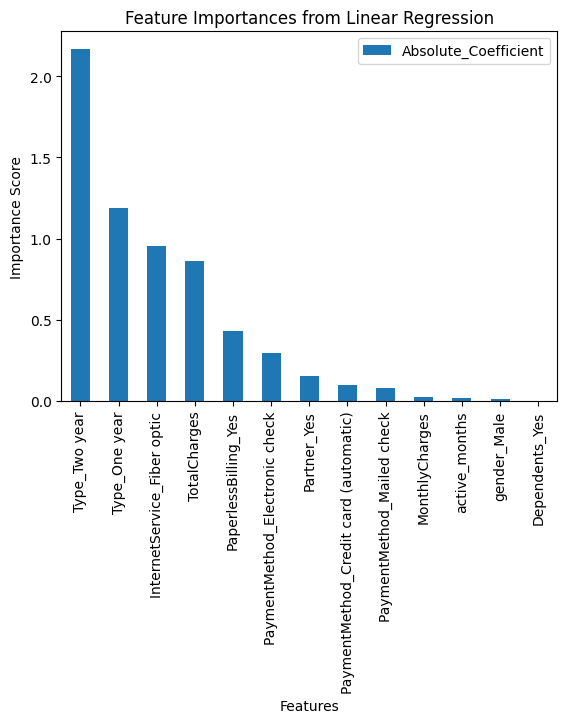

In [37]:
plt.figure(figsize=(10, 6))
sorted_coefficients.plot('Feature', 'Absolute_Coefficient', kind='bar')
plt.title('Feature Importances from Linear Regression')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

In [38]:
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                                  Feature  Importance
2             InternetService_Fiber optic    0.434519
4                           Type_Two year    0.160542
12                          active_months    0.126851
3                           Type_One year    0.096691
1                            TotalCharges    0.027120
5                    PaperlessBilling_Yes    0.022981
7          PaymentMethod_Electronic check    0.022746
0                          MonthlyCharges    0.021290
6   PaymentMethod_Credit card (automatic)    0.019468
9                             gender_Male    0.018515
11                         Dependents_Yes    0.017509
8              PaymentMethod_Mailed check    0.016729
10                            Partner_Yes    0.015039


<Figure size 1000x600 with 0 Axes>

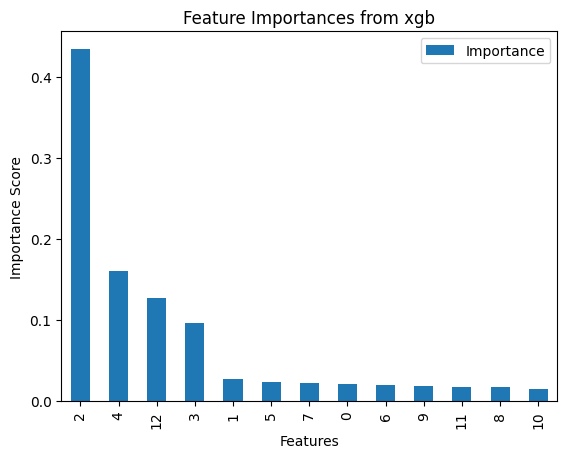

In [39]:
plt.figure(figsize=(10, 6))
feature_importance_df.plot(kind='bar')
plt.title('Feature Importances from xgb')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

In [40]:
importances = best_model_rf.feature_importances_
feature_names = X_train.columns
feature_importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("Feature Importances:")
print(feature_importance_series)

Feature Importances:
TotalCharges                             0.326072
MonthlyCharges                           0.268687
active_months                            0.105559
InternetService_Fiber optic              0.057495
Type_Two year                            0.044632
Type_One year                            0.036334
PaymentMethod_Electronic check           0.029245
gender_Male                              0.029047
PaperlessBilling_Yes                     0.026411
Partner_Yes                              0.025890
Dependents_Yes                           0.022465
PaymentMethod_Credit card (automatic)    0.015722
PaymentMethod_Mailed check               0.012442
dtype: float64


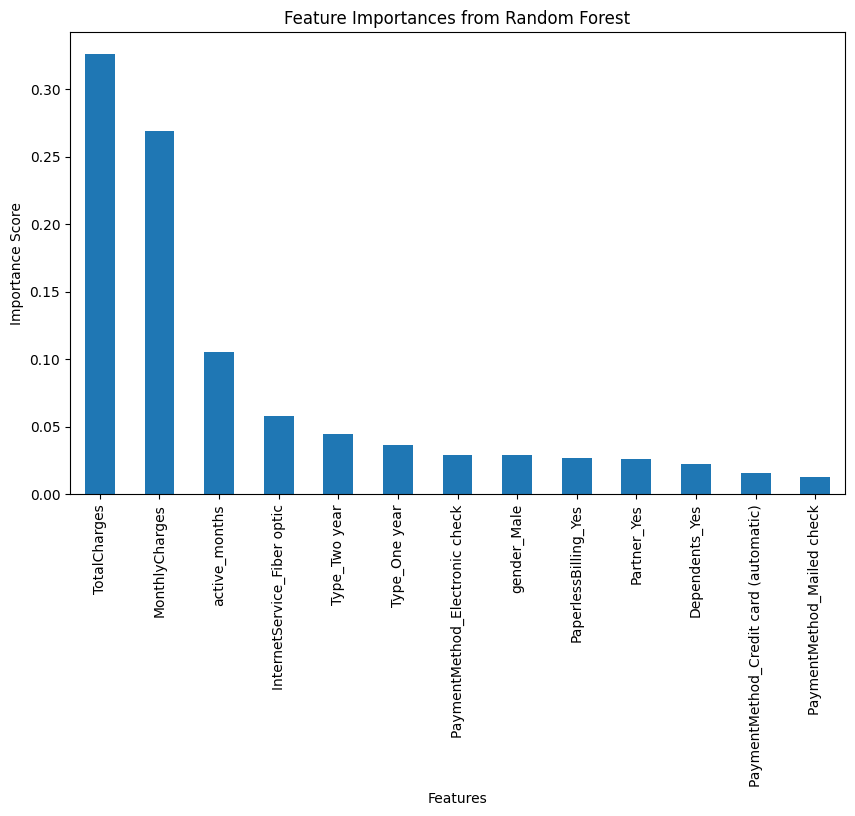

In [41]:
plt.figure(figsize=(10, 6))
feature_importance_series.plot(kind='bar')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

## The XGBoost model performed best with the validation data so we will be using it on our final test set.

In [42]:
y_pred_test = xgb_model.predict_proba(X_test)

auc_score_test = roc_auc_score(y_test, y_pred_test[:, 1])
print(f"ROC_AUC value for final test: {auc_score_test}")

threshold = 0.5
y_pred_binary_xgb = (y_pred_test[:, 1] >= threshold).astype(int)

accuracy_test = accuracy_score(y_test, y_pred_binary_xgb)
print(f"Accuracy value for final test: {accuracy_test}")

ROC_AUC value for final test: 0.8116131698581073
Accuracy value for final test: 0.7534435261707989


# Conclusion:
The XGBoost model has performed very well for the task of finding the target value No for the EndDate column with a final ROC_AUC score of 0.811 which will give us better insights on what products to push in order to retain customers and focus on sending promotions to customers who may be thinking of leaving soon. 